In [2]:
import os
import ants
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from nilearn import plotting
import saliency.core as saliency

import torch.nn.functional as F
from torch.utils.data import DataLoader

import sys
sys.path.append('/home/neuro-gnn-project/')
from datasets import MRIDatasetImage
from utils import get_transforms
from baseline_model import Conv5_FC3


In [3]:
tsv_path = Path('./10_sub_for_validation/labels_list_10')
caps = Path('./10_sub_for_validation/10_sub_for_validation')
source_path = Path('./10_sub_for_validation/model')  
task_diagnoses = ['AD','CN']
mask_type = None
task = '_'.join(task_diagnoses)
gt_mask = nib.load('./10_sub_for_validation/10_sub_for_validation/sub-ADNI002S4262/raw_data/ground_truth_mask_sub-ADNI002S4262.nii.gz').get_fdata()


In [4]:
model = Conv5_FC3().eval()
model.cuda()
model_path = os.path.join(source_path, 'model_best.pth.tar')
results = torch.load(model_path, map_location='cuda')
model.load_state_dict(results['model'])

<All keys matched successfully>

In [15]:
OUTPUT_DIR = './output'

class GetHeatmap():
    '''Aggregator class for different classic interpretation methods predictions.'''
    def __init__(self, size, save=False):
        self.size = size
        self.save = save
        if save:
            self.mask_dir = os.path.join(OUTPUT_DIR, 'img_mask')

    def grad_cam(self, model, image, logit, save_name=None):
        gc = GradCam(model)
        heatmap = gc.grad_cam(image, logit, self.size).cpu().numpy()
        
        if self.save:
            nib.save(nib.Nifti1Image(heatmap, affine=np.eye(4)),
                 os.path.join(self.mask_dir, '{}_gradcam_mask.nii.gz'.format(save_name)))
        
        return heatmap
    
    def guided_backprop(self, model, image, logit, save_name=None):
        gp = GuidedBackprop(model)
        pred = logit.data.max(1)[1].item()
        img_grad = gp.guided_backprop(image, pred)
        
        return img_grad

    def mean_pertrub(self, model, image, logit, save_name=None):
        mp = MeanPertrub(rep=9)
        pred = logit.data.max(1)[1].item()
        for param in model.parameters():
            param.requires_grad = False
        masks_pertrub = mp.get_masks(image, pred, model)
        
        return masks_pertrub
    
    def saliency_vanilla(self, model, image, logit, save_name=None):
        vanilla_method = Vanilla(model)
        vanilla_mask_3d, smoothgrad_mask_3d, value = vanilla_method.get_masks(image, logit)
        
        return (vanilla_mask_3d, smoothgrad_mask_3d)
    
    def saliency_vanilla_smooth(self, model, image, logit, save_name=None):
        return self.saliency_vanilla(model, image, logit, save_name=None)
    
    def saliency_intgrad(self, model, image, logit, save_name=None):
        vanilla_method = IntGrad(model)
        vanilla_mask_3d, smoothgrad_mask_3d, value = vanilla_method.get_masks(image, logit)
        return (vanilla_mask_3d, smoothgrad_mask_3d)
    
    def saliency_intgrad_smooth(self, model, image, logit, save_name=None):
        return self.saliency_intgrad(model, image, logit, save_name=None)
       

def get_masks(model, loader, mask_type='grad_cam', size=(180, 180, 180), save=None, save_binary=None, task='AD_CN'):
    masks = []
    labels = []
    proofs = []
    
    mask_dir = os.path.join(OUTPUT_DIR, 'img_mask')
    os.makedirs(mask_dir, exist_ok=True)
    
    heatmap_getter = GetHeatmap(size, save)
    
    for i, data in tqdm(enumerate(loader)):
        proofs.append(ants.image_read(data['image_path'][0]))
        image = data['image'].cuda()
        labels.append(data['label'].numpy().item())
        logit = model(image)
        
        name = data['image_path'][0][-80:-53]
        heatmap = getattr(heatmap_getter, mask_type)(model, image, logit, save_name=name)
        
        masks.append(heatmap)    
        
        del image, heatmap 
    
#     if not 'saliency' in mask_type:
    masks = [mask[1 if 'smooth' in mask_type else 0] for mask in masks] if 'saliency' in mask_type else masks
    concat = np.concatenate(masks, axis=0).squeeze(axis=1)
    labels_cn = np.array(labels) == 0
    labels_ad = np.array(labels) == 1
    mean_0 = concat[labels_cn].mean(axis=0)
    mean_1 = concat[labels_ad].mean(axis=0)
    nib.save(nib.Nifti1Image(mean_0, affine=np.eye(4)),
             os.path.join(OUTPUT_DIR, '{}_{}_mean_0_{}.nii.gz'.format(name, mask_type, task)))
    nib.save(nib.Nifti1Image(mean_1, affine=np.eye(4)),
             os.path.join(OUTPUT_DIR, '{}_{}_mean_1_{}.nii.gz'.format(name, mask_type, task)))
#     else:
        
        # masks: list of tuples (mask, smooth_mask)
#         save_img = ants.from_numpy(masks[0][0][0][0], spacing=proof.spacing, direction=proof.direction)
#         ants.image_write(save_img,  os.path.join(OUTPUT_DIR, '{}_{}_{}.nii.gz'.format(name, mask_type, task)))
#         vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
#         smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)
#         return masks
    
    return mean_0, mean_1

def display_interpretation(interp_img, data_img, cut_coords=None, threshold=0.35, method=None, name=None):
    fig, axes = plt.subplots(figsize=(16, 8))
    roi_img = nib.Nifti1Image(interp_img, affine=np.eye(4))
    bim_img = nib.Nifti1Image(np.squeeze(data_img['image']).cpu().detach().numpy(), affine=np.eye(4))
    if cut_coords is None:
        plotting.plot_roi(roi_img, bim_img, axes=axes, colorbar=True, cmap='jet',
                          threshold=threshold)
    else:
        plotting.plot_roi(roi_img, bim_img, cut_coords=cut_coords, axes=axes, 
                          colorbar=True, cmap='jet', threshold=threshold, cbar_tick_format='%.2g')
    plt.show()
    fig.savefig(f'{OUTPUT_DIR}/{method}'+(f'{name}' if name is not None else ''), bbox_inches='tight')

In [6]:
test_transforms, all_transforms = get_transforms('image', minmaxnormalization=True, data_augmentation=None)
test_df = pd.DataFrame()

for diagnosis in task_diagnoses:
    test_diagnosis_path = os.path.join(tsv_path, diagnosis + '.tsv')
    
    test_diagnosis_df = pd.read_csv(test_diagnosis_path, sep='\t')

    test_df = pd.concat([test_df, test_diagnosis_df])

    test_df.reset_index(inplace=True, drop=True)
    test_df["cohort"] = "single"

In [7]:
data_test = MRIDatasetImage(caps, data_df=test_df, preprocessing='t1-linear',
                            train_transformations=test_transforms, all_transformations=all_transforms,
                            labels=True)
test_loader = DataLoader(data_test, batch_size=1, shuffle=False,
                         num_workers=0, pin_memory=True)

In [6]:
!mkdir $OUTPUT_DIR

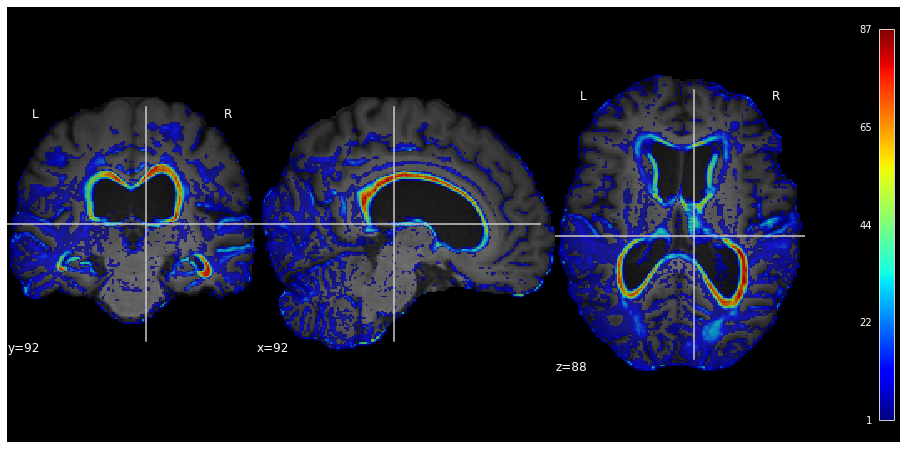

In [8]:
dataset_img = data_test.__getitem__(0)
display_interpretation(gt_mask, dataset_img, cut_coords=None, threshold=0.35, method='gt')

In [8]:
CUT_COORDS=(92, 92, 88)

## Interpretation methods
* Grad Cam 
* Guided Backprop
* MeanPertrub
* Some more...

### Grad Cam

**The Idea** is to take the gradients of the target class flowing into the final convolutional layer to produce a heatmap highlighting the important regions in the image to predict the concept.

1. Select the class of interest (target class)
2. Сalculate the gradient of the class logit and the activation maps 
3. Average over activations using the global average pooling
4. Obtain the neuron importance weights  coefficients α\_c\_k for each map (this weight α\_c\_k represents a partial linearization of the deep network downstream from A, and captures the ‘importance’ of feature map k for a target class c)
5. Consider a linear combination
6. Apply ReLU
7. Interpolate the heat-map (increase the dimension)


In [7]:
class GradCam():
    def __init__(self, model):
        self.model = model

    def grad_cam(self, input, logit, size):
        logit[:, logit.data.max(1)[1]].backward() ## get the gradient of the output with respect to the parameters of the model
        activation = self.model.get_activations(input).detach() # get the activations of the last convolutional layer
        act_grad = self.model.get_activations_gradient() # pull the gradients out of the model
        pool_act_grad = torch.mean(act_grad, dim=[2, 3, 4], keepdim=True) # pool the gradients across the channels  
        activation = activation * pool_act_grad # weight the channels by corresponding gradients
        heatmap = torch.sum(activation, dim=1) #
        heatmap = F.relu(heatmap) # relu on top of the heatmap
        heatmap /= torch.max(heatmap) # normalize the heatmap
        heatmap = F.interpolate(heatmap.unsqueeze(0), size[1:], mode='trilinear', align_corners=False)  # 58 70 58 interpolate the heat-map and project it onto the original image
        return heatmap

In [8]:
mask_type = 'grad_cam'

In [9]:
_, mean_1 = get_masks(model, test_loader, mask_type=mask_type, size=data_test.size, task=task, save=True)

20it [00:35,  1.78s/it]


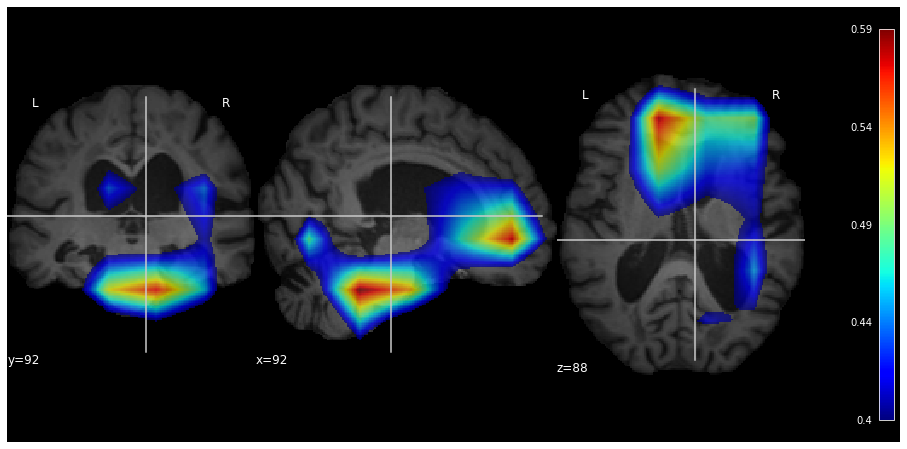

In [12]:
dataset_img = data_test.__getitem__(0)
display_interpretation(mean_1, dataset_img, cut_coords=CUT_COORDS, threshold=np.quantile(mean_1, q=0.92), method=mask_type)


### Guided Backprop

In [41]:
class GuidedBackprop():
    def __init__(self, model):
        self.model = model

    def guided_backprop(self, input, label):

        def hookfunc(module, gradInput, gradOutput):
            return tuple([(None if g is None else g.clamp(min=0)) for g in gradInput])

        input.requires_grad = True
        h = [0] * len(list(self.model.features) + list(self.model.classifier))
        for i, module in enumerate(list(self.model.features) + list(self.model.classifier)):
            if type(module) == torch.nn.ReLU:
                h[i] = module.register_backward_hook(hookfunc)

        self.model.eval()
        output = self.model(input)
        self.model.zero_grad()
        output[0][label].backward()
        grad = input.grad.data
        grad /= grad.max()
        return np.clip(grad.cpu().numpy(), 0, 1)

In [42]:
mean_0_gp, mean_1_gp = get_masks(model, test_loader, mask_type='guided_backprop', size=data_test.size)


20it [00:09,  2.12it/s]


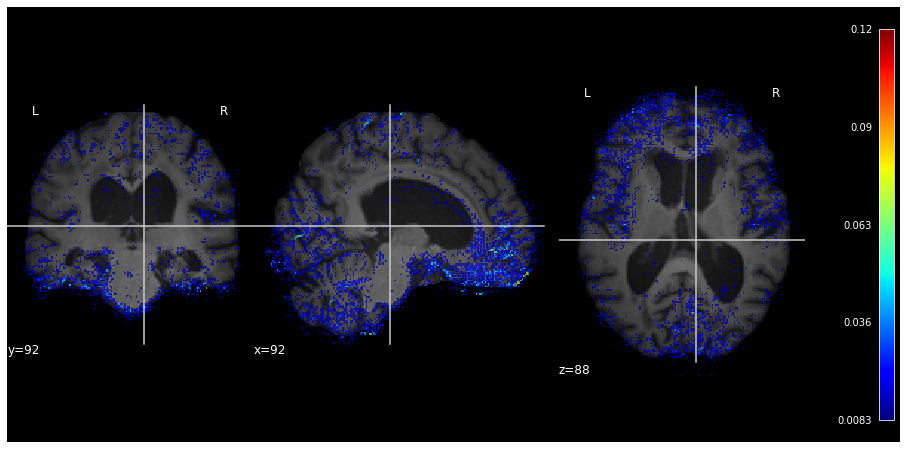

In [43]:
dataset_img = data_test.__getitem__(0)
display_interpretation(mean_1_gp, dataset_img, cut_coords=CUT_COORDS, threshold=np.quantile(mean_1_gp, q=0.92), method=mask_type)


### MeanPertrub

In [8]:
from scipy.ndimage import gaussian_filter
from torch.optim import Adam

def jittering(img, jit, C, D, H, W):
    return np.pad(img, [(0, 0), (0, jit), (0, jit), (0, jit)], mode='constant')

def upsample(mask, img_size):
    x = F.interpolate(mask, size=img_size, mode='trilinear', align_corners=False)
    return x

def np_to_torch(X, img_size, requires_grad=False):
    output = torch.tensor(X, requires_grad=requires_grad).cuda()
    return output.reshape(img_size)

def tv_norm(x, beta=1):
    d1 = torch.mean(torch.abs(x[:, :, :-1, :, :] - x[:, :, 1:, :, :]).pow(beta))
    d2 = torch.mean(torch.abs(x[:, :, :, :-1, :] - x[:, :, :, 1:, :]).pow(beta))
    d3 = torch.mean(torch.abs(x[:, :, :, :, :-1] - x[:, :, :, :, 1:]).pow(beta))
    tv = d1 + d2 + d3
    return tv


class GaussianFilter(torch.nn.Module):
    def __init__(self, k_size, g_filter):
        super(GaussianFilter, self).__init__()
        # self.device = device
        pad = (k_size - 1) // 2
        self.k_size = k_size
        self.conv = torch.nn.Conv3d(1, 1, k_size, padding=(pad, pad, pad), bias=None)
        self.conv.cuda()
        self.g_filter = g_filter

    def forward(self, x, sigma):
        n = np.zeros((self.k_size, self.k_size, self.k_size))
        n[self.k_size // 2 + 1, self.k_size // 2 + 1, self.k_size // 2 + 1] = 1
        k = self.g_filter(n, sigma=sigma)[None, None, :, :, :]
        self.conv.weight = torch.nn.Parameter(torch.from_numpy(k).float().cuda())
        for param in self.conv.parameters():
            param.requires_grad = False
        return self.conv(x)


class MeanPertrub():
    def __init__(self, mask_scale=4, blur_img=10, blur_mask=10, max_iter=300,
                 l1_coef=3, tv_coef=1, tv_beta=7, rep=10, jit=5, k_size=5, lr=1e-4):
        # self.device = device
        self.lr = lr
        self.mask_scale = 4
        self.blur_img = blur_img
        self.blur_mask = blur_mask
        self.max_iter = max_iter
        self.l1_coef = l1_coef
        self.tv_coef = tv_coef
        self.tv_beta = tv_beta
        self.rep = rep
        self.jit = jit
        self.filter_gaus = GaussianFilter(k_size, gaussian_filter)

    def get_masks(self, img, pred, model):
        res = []
        rw_max = self.max_iter // 5
        i = 0
        img = img.squeeze(axis=0)
        C, D, H, W = img.shape
        model_ans = pred
        mask = torch.ones((1, C, D // self.mask_scale, H // self.mask_scale, W // self.mask_scale),
                          requires_grad=True, device='cuda')
        optimizer = Adam([mask], lr=self.lr, betas=(0.9, 0.99), amsgrad=True, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        best_loss, best_mask = float('inf'), None
        for epoch in tqdm(range(self.max_iter)):
            mask_up = upsample(mask, img_size=(D, H, W))
            mask_up = self.filter_gaus(mask_up, self.blur_mask)
            total_pred_loss = 0
            for _ in range(self.rep):
                img_jit = jittering(img.cpu(), self.jit, C, D, H, W)
                j0 = np.random.randint(self.jit)
                j1 = np.random.randint(self.jit)
                j2 = np.random.randint(self.jit)
                img_jit = img_jit[:, j0:(D + j0), j1:(H + j1), j2:(W + j2)]
                img_torch = np_to_torch(img_jit, img_size=(1, C, D, H, W), requires_grad=False)
                blur = self.filter_gaus(img_torch, self.blur_img)
                perturbated_input = img_torch.mul(mask_up) + blur.mul(1 - mask_up).cuda()
                outputs = model(perturbated_input.float())  # problem
                prob = torch.exp(outputs)
                total_pred_loss += F.relu(prob[0, model_ans] - 0.05)
                del outputs, prob, perturbated_input, blur, img_torch, img_jit
            reg_loss = self.l1_coef * torch.mean(torch.abs(1 - mask)) + self.tv_coef * tv_norm(mask_up,
                                                                                               self.tv_beta)
            rw = 1 if epoch > rw_max else epoch / rw_max
            loss = total_pred_loss / self.rep + rw * reg_loss
            
            if epoch > 50 and loss.item() <= best_loss:
                best_loss = loss.item()
                best_mask = mask.clone().detach()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            mask.data.clamp_(0, 1)

        res_mask = upsample((1 - best_mask), img_size=(D, H, W))
        res.append(res_mask.cpu().numpy())
        i += 1
        return res_mask.cpu().numpy()

In [ ]:
mean_0_mp, mean_1_mp = get_masks(model, test_loader, mask_type='mean_pertrub', size=data_test.size)

In [ ]:
dataset_img = data_test.__getitem__(10)
display_interpretation(mean_1_gp, dataset_img, cut_coords=CUT_COORDS, threshold=np.quantile(mean_1_mp, q=0.8), method=mask_type)

### Saliency methods

In [10]:
class Saliency_abstract():
    def __init__(self, model, method):
        self.model = model
        self.method = method
        self.kwargs = dict()
        
    def compute_value(self, image):
        pass
        
    def call_model_function(self, images, call_model_args=None, expected_keys=None):
        target_class_idx =  call_model_args['class_idx_str']
        
        model = self.model.eval()
        images = torch.tensor(images).cuda().float()
        images.requires_grad = True
        
        logit = model(images[0])
        m = torch.nn.Softmax(dim=1)
        output = m(logit)
        
        if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
            outputs = output[:,target_class_idx]
            grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
            # grads = torch.movedim(grads[0], 1, 4)
            gradients = grads[0].detach().cpu().numpy()
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer_outputs = {}
            def conv_layer_forward(m, i, o):
                # move the RGB dimension to the last dimension
                conv_layer_outputs[saliency.base.CONVOLUTION_LAYER_VALUES] = torch.movedim(o, 1, 3).detach().numpy()

            def conv_layer_backward(m, i, o):
                # move the RGB dimension to the last dimension
                conv_layer_outputs[saliency.base.CONVOLUTION_OUTPUT_GRADIENTS] = torch.movedim(o[0], 1, 3).detach().numpy()
     
            conv_layer = model.features[16]
            conv_layer.register_forward_hook(conv_layer_forward)
            conv_layer.register_full_backward_hook(conv_layer_backward)
            
            one_hot = torch.zeros_like(output)
            one_hot[:,target_class_idx] = 1
            model.zero_grad()
            output.backward(gradient=one_hot, retain_graph=True)

            return conv_layer_outputs
        
    def get_masks(self, image, logit):
        interpret = self.method()
        prediction_class = np.argmax(logit[0].detach().cpu().numpy())
        call_model_args = {'class_idx_str': prediction_class}

        value = self.compute_value(image.cpu().numpy()) 
        vanilla_mask_3d = interpret.GetMask(value, self.call_model_function, call_model_args, **self.kwargs)
        smoothgrad_mask_3d = interpret.GetSmoothedMask(value, self.call_model_function, call_model_args, **self.kwargs)

        return vanilla_mask_3d, smoothgrad_mask_3d, value


### Vanilla interpretation

In [92]:
class Vanilla(Saliency_abstract):
    def __init__(self, model):
        method = saliency.GradientSaliency
        self.kwargs = dict()
        super().__init__(model, method)
        
    def compute_value(self, image):
        return -1*image[0][np.newaxis, ...]
            

In [93]:
mask_0_sal, mask_1_sal = get_masks(model, test_loader, mask_type='saliency_vanilla', size=data_test.size)

20it [03:40, 11.02s/it]


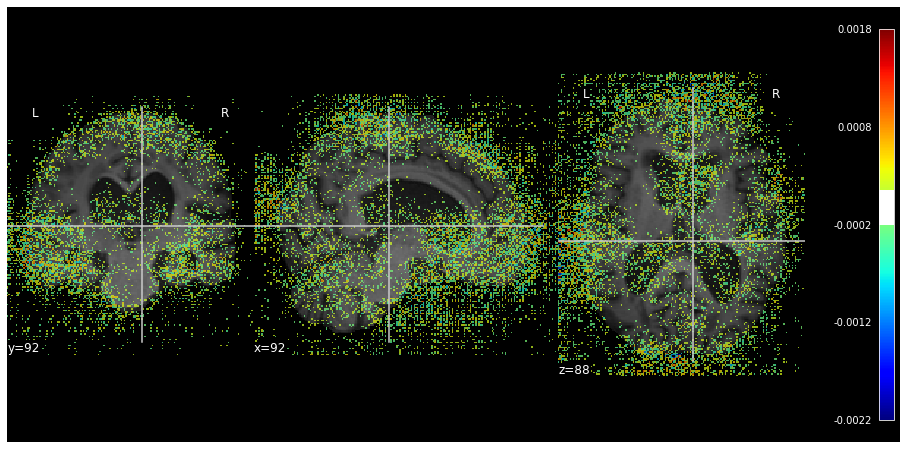

In [96]:
dataset_img = data_test.__getitem__(0)
# ad_m = './output/ADNI137S0972_ses-M00_T1w_sp_saliency_vanilla_mean_1_AD_CN.nii.gz'
display_interpretation(mask_1_sal, dataset_img, cut_coords=CUT_COORDS, threshold=np.quantile(mask_1_sal, q=0.92))


In [97]:
mask_0_salsmooth, mask_1_salsmooth = get_masks(model, test_loader, mask_type='saliency_vanilla_smooth', size=data_test.size)

20it [03:39, 10.98s/it]


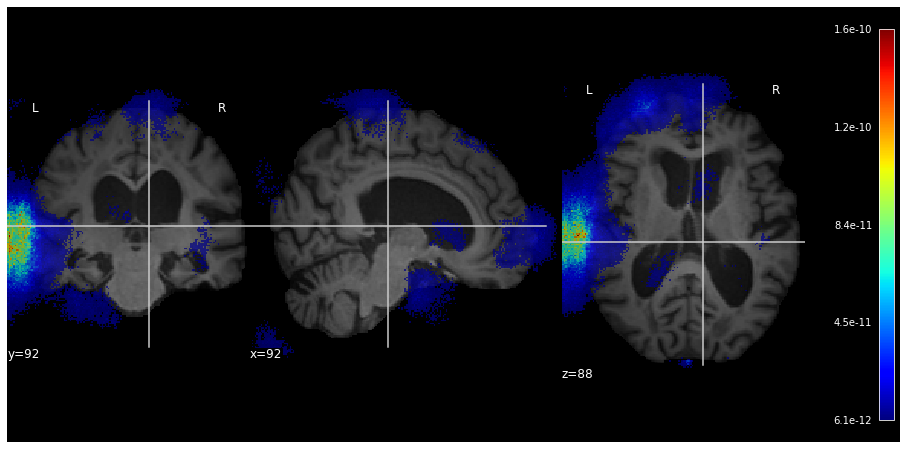

In [98]:
# ad_m = './output/ADNI137S0972_ses-M00_T1w_sp_saliency_vanilla_smooth_mean_0_AD_CN.nii.gz'
dataset_img = data_test.__getitem__(0)
display_interpretation(mask_1_salsmooth, dataset_img, cut_coords=CUT_COORDS, threshold=np.quantile(mask_1_salsmooth, q=0.92))


### Integrated Gradients

In [11]:
class IntGrad(Saliency_abstract):
    def __init__(self, model, x_steps=25, batch_size=1):
        method = saliency.IntegratedGradients
        self.kwargs = {'x_steps': 25, 'batch_size': 1}
        super().__init__(model, method)
        
    def compute_value(self, image):
        self.kwargs['x_baseline'] = np.full_like(image, 255)
        return image

In [12]:
mask_0_ig, mask_1_ig = get_masks(model, test_loader, mask_type='saliency_intgrad', size=data_test.size)


20it [40:25, 121.27s/it]


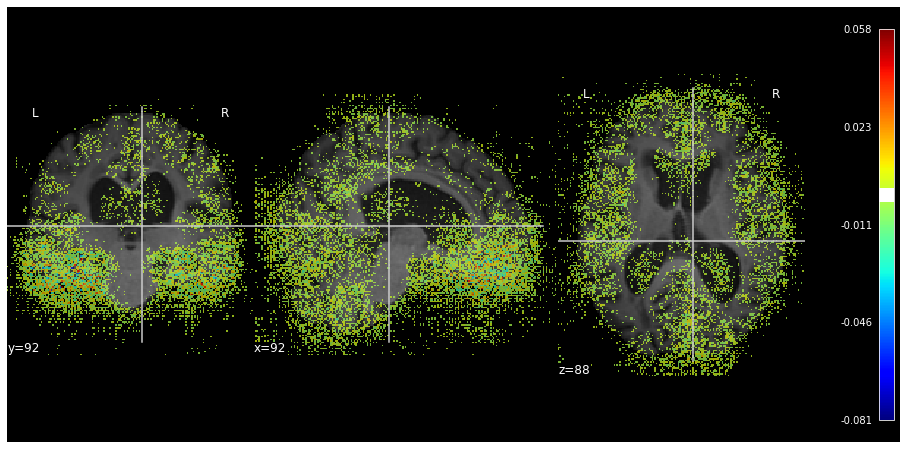

In [13]:
dataset_img = data_test.__getitem__(0)
display_interpretation(mask_0_ig, dataset_img, cut_coords=CUT_COORDS, threshold=np.quantile(mask_0_ig, q=0.92))


In [ ]:
mask_0_igsmooth, mask_1_igsmooth = get_masks(model, test_loader, mask_type='saliency_intgrad_smooth', size=data_test.size)


3it [05:48, 117.07s/it]

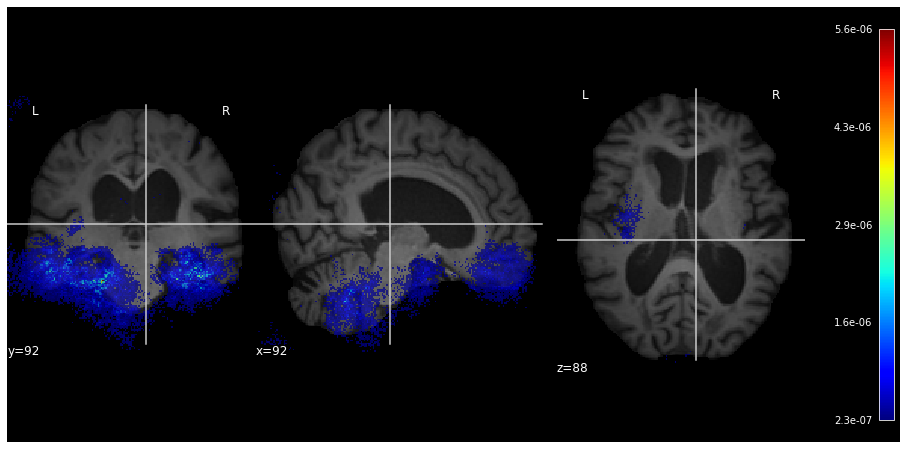

In [22]:
dataset_img = data_test.__getitem__(0)
display_interpretation(mask_1_igsmooth, dataset_img, cut_coords=CUT_COORDS, threshold=np.quantile(mask_0_igsmooth, q=0.97))
